In [1]:
# importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

O dataset é disponibilizado pelo Banco Central do Brasil, em sua página de dados abertos, no endereço: https://dadosabertos.bcb.gov.br/dataset/scr_data

Os dados são disponibilizados em arquivos mensais, por ano de referência. Neste trabalho, baixamos os dados de 2012 e selecionamos o arquivo do mês de dezembro de 2022.

Como se trata de uma base de dados grande (mais de 800 mil registros, em cada arquivo mensal), optamos por trabalhar somente com os dados das operações de crédito Pessoa Física (embora o arquivo possua também os dados de operações para Pessoa Jurídica).

Dada a extensão dessa base, ela não roda bem se carregado localmente, como no Jupyter ou no Visual Studio Code, sendo mais adequado o Google Colab, podendo demorar vários minutos para a carga dos dados. Optamos, portanto, por carregar inicialmente os dados em Excel, eliminar os dados de Pessoas Jurídicas, e salvá-los localmente, carregando no IDE os dados já pré-filtrados, para contemplar somente os dados de Pessoas Físicas.


In [2]:
# importando o dataset
dados = pd.read_excel("C:/Users/LUIZK/Dataset BCB Credito/planilha_202212PF.xlsx")

In [3]:
# visualizando o dataset
dados.head(3)

,data_base,uf,tcb,sr,cliente,ocupacao,cnae_secao,cnae_subclasse,porte,modalidade,...,a_vencer_ate_90_dias,a_vencer_de_91_ate_360_dias,a_vencer_de_361_ate_1080_dias,a_vencer_de_1081_ate_1800_dias,a_vencer_de_1801_ate_5400_dias,a_vencer_acima_de_5400_dias,vencido_acima_de_15_dias,carteira_ativa,carteira_inadimplida_arrastada,ativo_problematico
0,2022-12-31,AC,Bancário,S1,PF,PF - Aposentado/pensionista,-,-,PF - Acima de 20 salários mínimos,PF - Cartão de crédito,...,722.65,12689.82,0.00,0.00,0.00,0.0,2813.38,16225.85,0.00,0.00
1,2022-12-31,AC,Bancário,S1,PF,PF - Aposentado/pensionista,-,-,PF - Acima de 20 salários mínimos,PF - Cartão de crédito,...,4990017.63,1242329.92,152609.36,31858.72,0.00,0.0,328556.06,6745371.69,123984.25,260087.11
2,2022-12-31,AC,Bancário,S1,PF,PF - Aposentado/pensionista,-,-,PF - Acima de 20 salários mínimos,PF - Empréstimo com consignação em folha,...,1835015.57,4824698.55,12174468.74,10039746.09,11094339.68,0.0,76894.25,40045162.88,567775.56,653774.53


In [4]:
# renomeando a coluna 'porte' para 'renda'

dados.rename(columns={'porte' : 'renda'}, inplace=True)

In [5]:
# identificando o número de instâncias e de atributos
dados.shape

(135855, 23)

In [6]:
# procurando por valores nulos
print(dados.isnull().sum())

data_base                            0
uf                                   0
tcb                                  0
sr                                3831
cliente                              0
ocupacao                             0
cnae_secao                           0
cnae_subclasse                       0
renda                                0
modalidade                           0
origem                               0
indexador                            0
numero_de_operacoes                  0
a_vencer_ate_90_dias                 0
a_vencer_de_91_ate_360_dias          0
a_vencer_de_361_ate_1080_dias        0
a_vencer_de_1081_ate_1800_dias       0
a_vencer_de_1801_ate_5400_dias       0
a_vencer_acima_de_5400_dias          0
vencido_acima_de_15_dias             0
carteira_ativa                       0
carteira_inadimplida_arrastada       0
ativo_problematico                   0
dtype: int64


Verificamos que o único campo com valores nulos é o "sr". Segundo a metodologia do documento "SCR.Data" do Banco Central, na descrição dos campos, "SR" é definido como o segmento em que a instituição atua, sendo 5 as classes (S1, S2, S3, S4 e S5). Estas classes dizem respeito basicamente ao porte do banco, sendo S1 o maior, e S5 o menor. Dado que valores nulos podem trazer problemas por ocasião da execução do código, e os campos com "SR" nulo são pouco representativos (3831/135855, ou 2,82%), entendemos que poderemos excluir estes registros, sem prejuízos à análise dos dados.

In [7]:
# eliminando os registros com o atributo "sr" nulo
dados_clean = dados.dropna(axis=0)
dados_clean.shape

(132024, 23)

In [8]:
# verificando o tipo dos atributos
print(dados_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132024 entries, 0 to 135854
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   data_base                       132024 non-null  datetime64[ns]
 1   uf                              132024 non-null  object        
 2   tcb                             132024 non-null  object        
 3   sr                              132024 non-null  object        
 4   cliente                         132024 non-null  object        
 5   ocupacao                        132024 non-null  object        
 6   cnae_secao                      132024 non-null  object        
 7   cnae_subclasse                  132024 non-null  object        
 8   renda                           132024 non-null  object        
 9   modalidade                      132024 non-null  object        
 10  origem                          132024 non-null  object 

Verificamos também que o campo "numero_de_operacoes" possui um amplitude muito grande, que vai de "<=15" até 9.769.514. Isto revela que cada registro não contém informações somente de uma única operação ou de um único tomador (até porque um tomador não conseguiria contratar 9 milhões de operações de crédito!). 

Ao analisar a documentação do "SCR.Data - Painel de Operações de Crédito", em sua introdução, verificamos que os dados apresentados tratam-se de informações agregadas. Ou seja, a instituição financeira pode encaminhar os dados agregados de diversas operações que tenham as mesmas características (por exemplo, 'ocupacao', 'porte', 'modalidade', 'indexador' etc).

Experimentaremos, portanto, trabalhar somente com os registros que tenham o campo 'numero_de_operacoes' preenchido com a informação '<=15', pois desta forma é o dado que mais se aproxima do perfil individualizado do tomadro do crédito.


In [9]:
dados_clean['numero_de_operacoes'].value_counts()

<= 15    62205
16         965
17         957
18         867
19         824
         ...  
19769        1
12539        1
97049        1
24961        1
4362         1
Name: numero_de_operacoes, Length: 12221, dtype: int64

In [10]:
dados_clean = dados_clean[dados_clean["numero_de_operacoes"] == "<= 15"]
dados_clean.shape

(62205, 23)

Vamos salvar esta base de dados tratada para um arquivo em Excel.
Este arquivo poderá ser trabalho em paralelo para criar visualizações de dados interativas.

In [81]:
# nomeando o arquivo Excel
file_name = 'dados_clean.xlsx'

# salvando em Excel
dados_clean.to_excel("C:/Users/LUIZK/Dataset BCB Credito/dados_clean.xlsx")

In [11]:
# criando uma coluna para a classe "inadimplente"
# dado que o dataset não define quem seria inadimplente, consideramos quem 
# possuía 'ativo_problemático' > 0 como inadimplente.
# segundo a metodologia do "Painel de Operações de Crédito" do SCR.data, "ativo problemático"
# é o somatório dos créditos das operações de crédito classificadas com risco entre E e H, 
# operações reestruturadas e das operações consideradas na carteira inadimplida arrastada ("operações
# de crédito a vencer e vencidos que possuam alguma parcela vencida há mais de 90 dias").

inadimplente = [i if i == 0 else 1 for i in dados_clean['ativo_problematico']]
dados_clean['inadimplente'] = inadimplente

In [14]:
# criando um dataframe de adimplentes e outro de inadimplentes
adimplentes = dados_clean[dados_clean['inadimplente'] == 0.0]
inadimplentes = dados_clean[dados_clean['inadimplente'] == 1.0]

In [15]:
# calculando a proporção de inadimplentes
total, _ = dados_clean.shape
total_adimplentes, _ = dados_clean[dados_clean['inadimplente'] == 0.0].shape
total_inadimplentes, _ = dados_clean[dados_clean['inadimplente'] == 1.0].shape
print(f"Proporção de clientes adimplentes  : {total_adimplentes} {round(100 * total_adimplentes / total, 2)}%")
print(f"Proporção de clientes inadimplentes: {total_inadimplentes} {round(100 * total_inadimplentes / total, 2)}%")

Proporção de clientes adimplentes  : 42815 68.83%
Proporção de clientes inadimplentes: 19390 31.17%


Note que a proporção de 31% de clientes inadimplentes é muito alta, o que não parece razoável.
Porém, antes de enfrentarmos este problema, faremos uma análise de alguns atributos, para verificar o seu maior ou menor impacto sobre o resultado da inadimplência.
Faremos uma análise prévia dos atributos categóricos "uf", "sr", "ocupacao", "renda", "modalidade" e "indexador".

In [46]:
# analisando o atributo 'uf'
# categorias ordenadas
categorias_ordenadas = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA',
                        'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']

# Tabela com distribuição de população por categoria
populacao_por_categoria = dados_clean['uf'].value_counts(normalize=True) * 100
populacao_por_categoria = populacao_por_categoria.reindex(categorias_ordenadas)

# Tabela com distribuição de inadimplência por categoria
distribuicao_inadimplencia = inadimplentes['uf'].value_counts(normalize=True) * 100
distribuicao_inadimplencia = distribuicao_inadimplencia.reindex(categorias_ordenadas)

populacao = pd.DataFrame({'% População': populacao_por_categoria})
inadimplencia = pd.DataFrame({'% Inadimplência': distribuicao_inadimplencia})

# juntando as duas tabelas
tabela = pd.concat([populacao, inadimplencia], axis=1)
tabela = tabela.loc[categorias_ordenadas]
print(tabela)

    % População  % Inadimplência
AC     2.679849         3.053120
AL     2.940278         3.367715
AM     2.895266         3.383187
AP     2.290813         3.120165
BA     4.216703         4.492006
CE     3.334137         3.563693
DF     3.891970         3.986591
ES     4.060767         4.043321
GO     4.387107         4.089737
MA     3.477212         3.630737
MG     5.006028         4.218669
MS     3.930552         3.398659
MT     4.136323         3.630737
PA     3.519010         3.955647
PB     3.025480         3.145952
PE     3.305201         3.687468
PI     2.904911         3.310985
PR     4.994775         4.218669
RJ     4.264930         4.296029
RN     2.824532         3.197524
RO     3.388795         3.264569
RR     2.427458         3.022176
RS     5.158749         4.424961
SC     5.287356         4.528107
SE     3.035126         3.347086
SP     5.308255         4.368231
TO     3.308416         3.254255


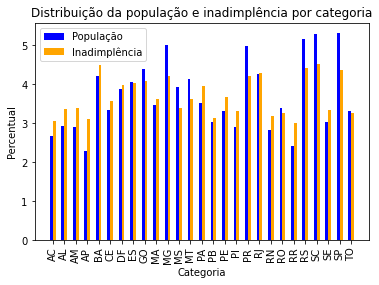

In [47]:
# plotando os dados de população e inadimplência por categoria de ocupação

# Define a largura das barras e a posição dos grupos no eixo x
bar_width = 0.25
r1 = np.arange(len(categorias_ordenadas))
r2 = [x + bar_width for x in r1]

# Cria a figura e os eixos
fig, ax = plt.subplots()

# Plota as barras de população e inadimplência
populacao_bars = ax.bar(r1, populacao_por_categoria, color='blue', width=bar_width, label='População')
inadimplencia_bars = ax.bar(r2, distribuicao_inadimplencia, color='orange', width=bar_width, label='Inadimplência')

# Adiciona rótulos, títulos e legendas ao gráfico
ax.set_xlabel('Categoria')
ax.set_ylabel('Percentual')
ax.set_title('Distribuição da população e inadimplência por categoria')
ax.set_xticks([r + bar_width / 2 for r in range(len(categorias_ordenadas))])
ax.set_xticklabels(categorias_ordenadas, rotation=90)
ax.legend()

# Exibição do gráfico
plt.show()

In [48]:
# analisando o atributo 'sr', que se refere ao porte da instituição
# categorias ordenadas
categorias_ordenadas = ['S1', 'S2', 'S3', 'S4', 'S5']

# Tabela com distribuição de população por categoria
populacao_por_categoria = dados_clean['sr'].value_counts(normalize=True) * 100
populacao_por_categoria = populacao_por_categoria.reindex(categorias_ordenadas)

# Tabela com distribuição de inadimplência por categoria
distribuicao_inadimplencia = inadimplentes['sr'].value_counts(normalize=True) * 100
distribuicao_inadimplencia = distribuicao_inadimplencia.reindex(categorias_ordenadas)

populacao = pd.DataFrame({'% População': populacao_por_categoria})
inadimplencia = pd.DataFrame({'% Inadimplência': distribuicao_inadimplencia})

# juntando as duas tabelas
tabela = pd.concat([populacao, inadimplencia], axis=1)
tabela = tabela.loc[categorias_ordenadas]
print(tabela)

    % População  % Inadimplência
S1    23.501326        29.845281
S2     8.160116        11.629706
S3    24.422474        20.154719
S4    23.065670        18.932439
S5    20.850414        19.437855


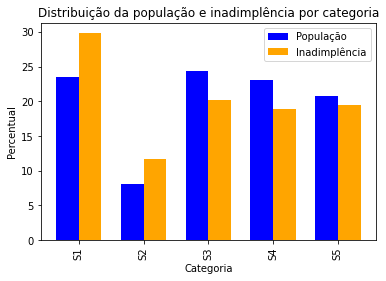

In [49]:
# plotando os dados de população e inadimplência por categoria de ocupação

# Define a largura das barras e a posição dos grupos no eixo x
bar_width = 0.35
r1 = np.arange(len(categorias_ordenadas))
r2 = [x + bar_width for x in r1]

# Cria a figura e os eixos
fig, ax = plt.subplots()

# Plota as barras de população e inadimplência
populacao_bars = ax.bar(r1, populacao_por_categoria, color='blue', width=bar_width, label='População')
inadimplencia_bars = ax.bar(r2, distribuicao_inadimplencia, color='orange', width=bar_width, label='Inadimplência')

# Adiciona rótulos, títulos e legendas ao gráfico
ax.set_xlabel('Categoria')
ax.set_ylabel('Percentual')
ax.set_title('Distribuição da população e inadimplência por categoria')
ax.set_xticks([r + bar_width / 2 for r in range(len(categorias_ordenadas))])
ax.set_xticklabels(categorias_ordenadas, rotation=90)
ax.legend()

# Exibição do gráfico
plt.show()

In [50]:
# analisando o atributo 'ocupacao'
# categorias ordenadas
categorias_ordenadas = ['PF - Servidor ou empregado público',
                        'PF - Empregado de entidades sem fins lucrativos',
                        'PF - Empregado de empresa privada',
                        'PF - Aposentado/pensionista',
                        'PF - Autônomo',
                        'PF - Empresário',
                        'PF - MEI',
                        'PF - Outros']

# Tabela com distribuição de população por categoria
populacao_por_categoria = dados_clean['ocupacao'].value_counts(normalize=True) * 100
populacao_por_categoria = populacao_por_categoria.reindex(categorias_ordenadas)

# Tabela com distribuição de inadimplência por categoria
distribuicao_inadimplencia = inadimplentes['ocupacao'].value_counts(normalize=True) * 100
distribuicao_inadimplencia = distribuicao_inadimplencia.reindex(categorias_ordenadas)

populacao = pd.DataFrame({'% População': populacao_por_categoria})
inadimplencia = pd.DataFrame({'% Inadimplência': distribuicao_inadimplencia})

# juntando as duas tabelas
tabela = pd.concat([populacao, inadimplencia], axis=1)
tabela = tabela.loc[categorias_ordenadas]
print(tabela)

                                                 % População  % Inadimplência
PF - Servidor ou empregado público                 12.952335        12.037133
PF - Empregado de entidades sem fins lucrativos     7.356322         6.683858
PF - Empregado de empresa privada                  13.558396        13.068592
PF - Aposentado/pensionista                        12.235351        11.660650
PF - Autônomo                                      14.114621        14.373388
PF - Empresário                                    14.833213        14.631253
PF - MEI                                            9.793425        11.356369
PF - Outros                                        15.156338        16.188757


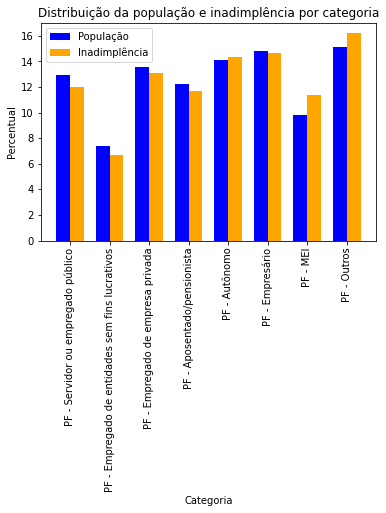

In [51]:
# plotando os dados de população e inadimplência por categoria de ocupação

# Define a largura das barras e a posição dos grupos no eixo x
bar_width = 0.35
r1 = np.arange(len(categorias_ordenadas))
r2 = [x + bar_width for x in r1]

# Cria a figura e os eixos
fig, ax = plt.subplots()

# Plota as barras de população e inadimplência
populacao_bars = ax.bar(r1, populacao_por_categoria, color='blue', width=bar_width, label='População')
inadimplencia_bars = ax.bar(r2, distribuicao_inadimplencia, color='orange', width=bar_width, label='Inadimplência')

# Adiciona rótulos, títulos e legendas ao gráfico
ax.set_xlabel('Categoria')
ax.set_ylabel('Percentual')
ax.set_title('Distribuição da população e inadimplência por categoria')
ax.set_xticks([r + bar_width / 2 for r in range(len(categorias_ordenadas))])
ax.set_xticklabels(categorias_ordenadas, rotation=90)
ax.legend()

# Exibição do gráfico
plt.show()

In [52]:
# analisando o atributo 'renda'

# categorias ordenadas
categorias_ordenadas = ['PF - Indisponível                            ',
                        'PF - Sem rendimento                          ',
                        'PF - Até 1 salário mínimo                    ',
                        'PF - Mais de 1 a 2 salários mínimos          ',
                        'PF - Mais de 2 a 3 salários mínimos          ',
                        'PF - Mais de 3 a 5 salários mínimos          ',
                        'PF - Mais de 5 a 10 salários mínimos         ',
                        'PF - Mais de 10 a 20 salários mínimos        ',
                        'PF - Acima de 20 salários mínimos            ']

# Tabela com distribuição de população por categoria
populacao_por_categoria = dados_clean['renda'].value_counts(normalize=True) * 100
populacao_por_categoria = populacao_por_categoria.reindex(categorias_ordenadas)

# Tabela com distribuição de inadimplência por categoria
distribuicao_inadimplencia = inadimplentes['renda'].value_counts(normalize=True) * 100
distribuicao_inadimplencia = distribuicao_inadimplencia.reindex(categorias_ordenadas)

populacao = pd.DataFrame({'% População': populacao_por_categoria})
inadimplencia = pd.DataFrame({'% Inadimplência': distribuicao_inadimplencia})

# juntando as duas tabelas
tabela = pd.concat([populacao, inadimplencia], axis=1)
tabela = tabela.loc[categorias_ordenadas]
print(tabela)

                                               % População  % Inadimplência
PF - Indisponível                                 7.332208         8.287777
PF - Sem rendimento                               5.571899         6.998453
PF - Até 1 salário mínimo                         9.833615        12.604435
PF - Mais de 1 a 2 salários mínimos              11.513544        13.610108
PF - Mais de 2 a 3 salários mínimos              11.785226        13.047963
PF - Mais de 3 a 5 salários mínimos              12.936259        12.418773
PF - Mais de 5 a 10 salários mínimos             13.807572        12.470346
PF - Mais de 10 a 20 salários mínimos            13.486054        11.175864
PF - Acima de 20 salários mínimos                13.733623         9.386282


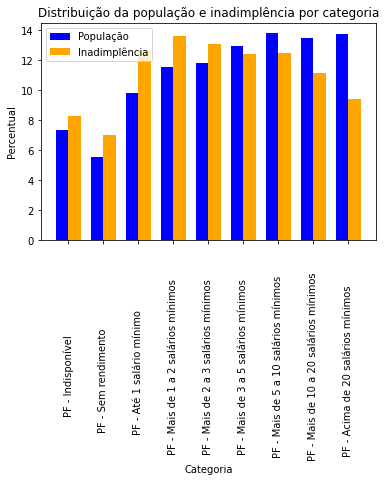

In [53]:
# plotando os dados de população e inadimplência por categoria de renda

# Define a largura das barras e a posição dos grupos no eixo x
bar_width = 0.35
r1 = np.arange(len(categorias_ordenadas))
r2 = [x + bar_width for x in r1]

# Cria a figura e os eixos
fig, ax = plt.subplots()

# Plota as barras de população e inadimplência
populacao_bars = ax.bar(r1, populacao_por_categoria, color='blue', width=bar_width, label='População')
inadimplencia_bars = ax.bar(r2, distribuicao_inadimplencia, color='orange', width=bar_width, label='Inadimplência')

# Adiciona rótulos, títulos e legendas ao gráfico
ax.set_xlabel('Categoria')
ax.set_ylabel('Percentual')
ax.set_title('Distribuição da população e inadimplência por categoria')
ax.set_xticks([r + bar_width / 2 for r in range(len(categorias_ordenadas))])
ax.set_xticklabels(categorias_ordenadas, rotation=90)
ax.legend()

# Exibição do gráfico
plt.show()

In [54]:
# analisando o atributo 'modalidade'
# categorias ordenadas
categorias_ordenadas = ['PF - Cartão de crédito',
                        'PF - Empréstimo com consignação em folha',
                        'PF - Empréstimo sem consignação em folha',
                        'PF - Habitacional',
                        'PF - Outros créditos',
                        'PF - Rural e agroindustrial',
                        'PF - Veículos']

# Tabela com distribuição de população por categoria
populacao_por_categoria = dados_clean['modalidade'].value_counts(normalize=True) * 100
populacao_por_categoria = populacao_por_categoria.reindex(categorias_ordenadas)

# Tabela com distribuição de inadimplência por categoria
distribuicao_inadimplencia = inadimplentes['modalidade'].value_counts(normalize=True) * 100
distribuicao_inadimplencia = distribuicao_inadimplencia.reindex(categorias_ordenadas)

populacao = pd.DataFrame({'% População': populacao_por_categoria})
inadimplencia = pd.DataFrame({'% Inadimplência': distribuicao_inadimplencia})

# juntando as duas tabelas
tabela = pd.concat([populacao, inadimplencia], axis=1)
tabela = tabela.loc[categorias_ordenadas]
print(tabela)

                                          % População  % Inadimplência
PF - Cartão de crédito                       6.843501         6.864363
PF - Empréstimo com consignação em folha     9.594084        11.340897
PF - Empréstimo sem consignação em folha    14.505265        18.623002
PF - Habitacional                           13.362270         5.482207
PF - Outros créditos                        28.140825        36.596184
PF - Rural e agroindustrial                 16.892533        11.170707
PF - Veículos                               10.661522         9.922641


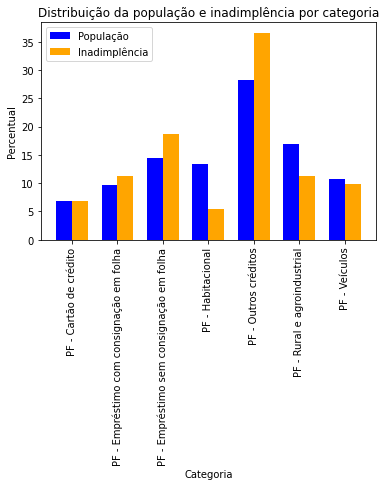

In [55]:
# plotando os dados de população e inadimplência por categoria de modalidade de empréstimo

# Define a largura das barras e a posição dos grupos no eixo x
bar_width = 0.35
r1 = np.arange(len(categorias_ordenadas))
r2 = [x + bar_width for x in r1]

# Cria a figura e os eixos
fig, ax = plt.subplots()

# Plota as barras de população e inadimplência
populacao_bars = ax.bar(r1, populacao_por_categoria, color='blue', width=bar_width, label='População')
inadimplencia_bars = ax.bar(r2, distribuicao_inadimplencia, color='orange', width=bar_width, label='Inadimplência')

# Adiciona rótulos, títulos e legendas ao gráfico
ax.set_xlabel('Categoria')
ax.set_ylabel('Percentual')
ax.set_title('Distribuição da população e inadimplência por categoria')
ax.set_xticks([r + bar_width / 2 for r in range(len(categorias_ordenadas))])
ax.set_xticklabels(categorias_ordenadas, rotation=90)
ax.legend()

# Exibição do gráfico
plt.show()

In [56]:
# analisando o atributo 'indexador'
# categorias ordenadas
categorias_ordenadas = ['Prefixado',
                        'Pós-fixado',
                        'Flutuantes',
                        'Índices de preços',
                        'TCR/TRFC',
                        'Outros indexadores']

# Tabela com distribuição de população por categoria
populacao_por_categoria = dados_clean['indexador'].value_counts(normalize=True) * 100
populacao_por_categoria = populacao_por_categoria.reindex(categorias_ordenadas)

# Tabela com distribuição de inadimplência por categoria
distribuicao_inadimplencia = inadimplentes['indexador'].value_counts(normalize=True) * 100
distribuicao_inadimplencia = distribuicao_inadimplencia.reindex(categorias_ordenadas)

populacao = pd.DataFrame({'% População': populacao_por_categoria})
inadimplencia = pd.DataFrame({'% Inadimplência': distribuicao_inadimplencia})

# juntando as duas tabelas
tabela = pd.concat([populacao, inadimplencia], axis=1)
tabela = tabela.loc[categorias_ordenadas]
print(tabela)

                    % População  % Inadimplência
Prefixado             48.296761        50.562145
Pós-fixado            20.945262        28.303249
Flutuantes            13.039145         7.441980
Índices de preços      9.203440         5.069624
TCR/TRFC               1.975725         0.412584
Outros indexadores     6.539667         8.210418


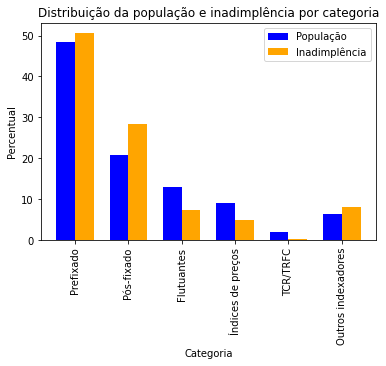

In [57]:
# plotando os dados de população e inadimplência por categoria de modalidade de empréstimo

# Define a largura das barras e a posição dos grupos no eixo x
bar_width = 0.35
r1 = np.arange(len(categorias_ordenadas))
r2 = [x + bar_width for x in r1]

# Cria a figura e os eixos
fig, ax = plt.subplots()

# Plota as barras de população e inadimplência
populacao_bars = ax.bar(r1, populacao_por_categoria, color='blue', width=bar_width, label='População')
inadimplencia_bars = ax.bar(r2, distribuicao_inadimplencia, color='orange', width=bar_width, label='Inadimplência')

# Adiciona rótulos, títulos e legendas ao gráfico
ax.set_xlabel('Categoria')
ax.set_ylabel('Percentual')
ax.set_title('Distribuição da população e inadimplência por categoria')
ax.set_xticks([r + bar_width / 2 for r in range(len(categorias_ordenadas))])
ax.set_xticklabels(categorias_ordenadas, rotation=90)
ax.legend()

# Exibição do gráfico
plt.show()

Analisamos a distribuição da população e da inadimplência por 6 atributos: "uf", "sr", "ocupacao", "renda", "modalidade" e "indexador".

Verificamos que no atributo "uf", que se refere à Unidade da Federação onde a operação de crédito foi contratada, há uma certa desigualdade na distribuição das operações de crédito quando comparadas com a distribuição da inadimplência. Enquanto se verifica uma menor inadimplência nos estados de MG, SP, PR, SC e RS, nos estados de AP, PA e RR, o inverso se observa. Então, a "uf" é uma variável importante à análise.

O "sr" se refere ao porte do banco, sendo S1 o maior, e S5 o menor. Neste sentido, observa-se que a inadimplência se observa proporcionalmente maior nos grandes bancos, segmentos S1 e S2.

O atributo "ocupacao" mostra um equilíbrio grande entre a distribuição pela população e a distribuição da inadimplência, de modo que ele pouco reflete no resultado. Em outras palavras, dentre as ocupações listadas, não há uma que seja mais propensa à inadimplência do que outra, se considerarmos as informações deste dataset.

No atributo renda, verificamos um certo desbalanceamento, onde a faixa de maior renda ("Acima de 20 salários mínimos") possui uma inadimplência proporcionalmente menor, enquanto que as faixas "Até 1 salário mínimo" e "Mais de 1 até 2 salários mínimos" possuem maior dificuldade de cumprir com o pactuado. Trata-se de uma variável importante, portanto, para a análise.

Na "modalidade", também verificamos categorias mais problemáticas em termos de inadimplência do que outras. Também se trata de uma variável importante para o estudo.

Por fim, no "indexador", verificamos uma variação moderada da influência da forma de atualização do saldo devedor sobre a maior ou menor dificuldade de adimplemento das obrigações. 

----------------------------------------------------------------------------------------------------------------

Voltando à questão do alto índice de inadimplência (cerca de 31%), que não parece razoável. 

O fato de que os registros podem ter não somente um, mas vários registros ('numero_de_operacoes' até o máximo de 15) está distorcendo os números.

Então a simples análise dos registros considerando 0 adimplente e 1 inadimplente ainda não está adequada.
Para uma melhor aproximação da realidade, então, vamos eliminar a coluna recém-criada 'inadimplente', e classificar os registros por faixa, o qual denominaremos 'score', que terá como valores '0' (para riscos bons), '1' (para riscos médios) e '2' (para riscos ruins).

Embora ainda não seja uma análise ideal (que seria os dados individualizados por operação de crédito), é a melhor aproximação que conseguimos da realidade.

Para a classificação dos riscos, consideramos o quociente 'ativo_problematico' / 'carteira_ativa', que mede o quanto os ativos com problemas representam da carteira total em cada registro de nosso banco de dados.
Arbitramos como '0' (risco bom) os quocientes de 0% até 5%, '1' (risco médio) os quocientes maiores que 5% e até 13,65%, e '2' (risco ruim) os quocientes maiores que 13,75%.

A justificativa para adoção destes percentuais é a seguinte: 5% é a taxa de inadimplência aceitável, conforme se observa em diversos artigos na internet (embora estes não apresentem qual o embasamento para este percentual). 13,65% é a taxa da CDI acumulada de 2022. O CDI é uma das fontes de captação de recursos pelas instituições financeiras. Portanto, ter perdas superiores ao custo de captação representa a duplicação de um prejuízo, se se considerar o custo de oportunidade: mais vale emprestar para outras instituições financeiras do que operar no varejo.

Embora a matemática da operação não seja tão simplista, é apenas uma forma para definir uma classificação.
Os percentuais abaixo indicados são, portanto, apenas uma sugestão de classificação, podendo ser arbitrados outros.

In [58]:
# criando uma função para classificar o risco:
def get_risk(score):
    if score <= bom:
        return 0
    elif score <= medio:
        return 1
    else:
        return 2

# definindo a classificação de risco
bom = 0.05  # menor ou igual a 5%
medio = 0.1365 # maior que 5% e menor ou igual a 13,65% ## ruim > 13,65%

# calculando a classificação de risco, com um atributo provisório "perc_carteira_problema"
dados_clean['perc_carteira_problema'] = dados_clean['ativo_problematico'] / dados_clean['carteira_ativa']

# criando uma coluna "score" com a classificação do risco
dados_clean['score'] = dados_clean['perc_carteira_problema'].apply(get_risk)
dados_clean.head(5)

,data_base,uf,tcb,sr,cliente,ocupacao,cnae_secao,cnae_subclasse,renda,modalidade,...,a_vencer_de_1081_ate_1800_dias,a_vencer_de_1801_ate_5400_dias,a_vencer_acima_de_5400_dias,vencido_acima_de_15_dias,carteira_ativa,carteira_inadimplida_arrastada,ativo_problematico,inadimplente,perc_carteira_problema,score
0,2022-12-31,AC,Bancário,S1,PF,PF - Aposentado/pensionista,-,-,PF - Acima de 20 salários mínimos,PF - Cartão de crédito,...,0.0,0.00,0.00,2813.38,16225.85,0.0,0.0,0.0,0.0,0
4,2022-12-31,AC,Bancário,S1,PF,PF - Aposentado/pensionista,-,-,PF - Acima de 20 salários mínimos,PF - Habitacional,...,447813.3,934450.37,200864.96,0.00,2669678.76,0.0,0.0,0.0,0.0,0
5,2022-12-31,AC,Bancário,S1,PF,PF - Aposentado/pensionista,-,-,PF - Acima de 20 salários mínimos,PF - Outros créditos,...,0.0,0.00,0.00,198.35,198.35,0.0,0.0,0.0,0.0,0
7,2022-12-31,AC,Bancário,S1,PF,PF - Aposentado/pensionista,-,-,PF - Acima de 20 salários mínimos,PF - Outros créditos,...,93790.9,125128.87,0.00,0.00,469667.92,0.0,0.0,0.0,0.0,0
10,2022-12-31,AC,Bancário,S1,PF,PF - Aposentado/pensionista,-,-,PF - Acima de 20 salários mínimos,PF - Rural e agroindustrial,...,0.0,0.00,0.00,0.00,879535.90,0.0,0.0,0.0,0.0,0


In [59]:
# contagem dos registros de acordo com a sua classificação

dados_clean['score'].value_counts()

0    44887
2    15083
1     2235
Name: score, dtype: int64

<AxesSubplot:>

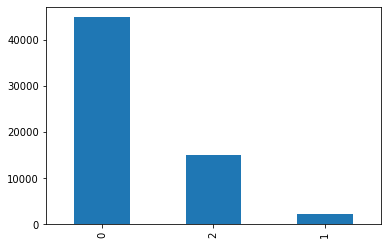

In [60]:
# a mesma informação, sob a forma gráfica

dados_clean['score'].value_counts().plot.bar()

O procedimento seguinte é converter as colunas categóricas em numéricas. Este procedimento é necessário porque muitas bibliotecas do python para aprendizagem de máquina não conseguem trabalhar com dados categóricos. Assim, para evitar erros durante a execução do projeto, converteremos estes dados para o formato numérico. 

Nos atributos onde não existe uma ordem de importância dos valores (por exemplo: ocupação), o ideal é trabalhar com dados em formato binário, 0 e 1. Assim, são criadas tantas colunas quanto os valores únicos existentes, cada uma recebendo o valor 0 (se o atributo, para aquele registro, for falso) ou 1 (se verdadeiro). Para isso, usamos a função One Hot Encoder.

Já nos atributos onde a ordem dos valores importa (por exemplo, 'porte', que indica a renda), os registros são convertidos para números de 0 até n. A função que utilizaremos para isso é a Label Encoder.

In [61]:
# importando a biblioteca
from sklearn.preprocessing import OneHotEncoder

# convertendo colunas categóricas em numéricas com OneHotEncoder
one_hot = pd.get_dummies(dados_clean['sr'])
dados_clean = pd.concat([dados_clean, one_hot], axis=1)

In [62]:
one_hot = pd.get_dummies(dados_clean['ocupacao'])
dados_clean = pd.concat([dados_clean, one_hot], axis=1)

In [63]:
one_hot = pd.get_dummies(dados_clean['modalidade'])
dados_clean = pd.concat([dados_clean, one_hot], axis=1)

In [64]:
one_hot = pd.get_dummies(dados_clean['indexador'])
dados_clean = pd.concat([dados_clean, one_hot], axis=1)

In [65]:
# importando a biblioteca
from sklearn.preprocessing import LabelEncoder

# convertendo coluna categórica em númerica com LabelEncoder
# neste caso, a ordem dos dados importa, por isso não foi utilizado o OneHotEncoder

dados_clean['renda'] = pd.DataFrame({'renda': ['PF - Acima de 20 salários mínimos', 
        'PF - Até 1 salário mínimo', 'PF - Indisponível', 
        'PF - Mais de 1 a 2 salários mínimos', 'PF - Mais de 10 a 20 salários mínimos', 
        'PF - Mais de 2 a 3 salários mínimos', 'PF - Mais de 3 a 5 salários mínimos',
        'PF - Mais de 5 a 10 salários minimos', 'PF - Sem rendimento']})
cat_renda = pd.Categorical(dados_clean['renda'], categories=['PF - Sem rendimento', 'PF - Indisponível', 
        'PF - Até 1 salário mínimo', 'PF - Mais de 1 a 2 salários mínimos', 
        'PF - Mais de 2 a 3 salários mínimos', 'PF - Mais de 3 a 5 salários mínimos',
        'PF - Mais de 5 a 10 salários mínimos', 'PF - Mais de 10 a 20 salários mínimos',
        'PF - Acima de 20 salários'],ordered=True)
encoder = LabelEncoder()
dados_clean['renda'] = encoder.fit_transform(cat_renda)

In [66]:
# eliminando as colunas que não seram utilizadas em nosso trabalho
# a coluna 'data_base' será eliminada porque todos os dados são da mesma data_base (31/12/2022)
# as colunas 'cnae_secao' e 'cnae_subclasse' serão eliminadas porque elas se aplicam às pessoas jurídicas
# a coluna 'origem' será eliminada uma vez que a modalidade de crédito já define a tipologia de origem
dados_clean.drop(['data_base', 'cnae_secao', 'cnae_subclasse', 'origem'], axis=1, inplace = True)
print(dados_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62205 entries, 0 to 135854
Data columns (total 48 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   uf                                               62205 non-null  object 
 1   tcb                                              62205 non-null  object 
 2   sr                                               62205 non-null  object 
 3   cliente                                          62205 non-null  object 
 4   ocupacao                                         62205 non-null  object 
 5   renda                                            62205 non-null  int32  
 6   modalidade                                       62205 non-null  object 
 7   indexador                                        62205 non-null  object 
 8   numero_de_operacoes                              62205 non-null  object 
 9   a_vencer_ate_90_dias       

Na definição das colunas preditoras, foram deliberadamente excluídos os atributos "carteira_inadimplida_arrastada" e "ativo_problematico". Estes atributos, por serem muito indicativos da classe objeto, não seriam úteis ao treinamento, visto que levaria a um sobreajuste (overfitting) do modelo de aprendizagem em relação à base de treino, o que seria ruim para a generalização do modelo,.

In [67]:
# definindo as colunas preditoras x e a classe predita y

x = np.array(dados_clean[['S1', 'S2', 'S3', 'S4', 'S5',
                          'PF - Aposentado/pensionista', 
                          'PF - Autônomo', 
                          'PF - Empregado de empresa privada', 
                          'PF - Empregado de entidades sem fins lucrativos', 
                          'PF - Empresário', 
                          'PF - MEI', 
                          'PF - Outros', 
                          'PF - Servidor ou empregado público', 
                          'renda', 
                          'PF - Cartão de crédito', 
                          'PF - Empréstimo com consignação em folha', 
                          'PF - Empréstimo sem consignação em folha', 
                          'PF - Habitacional', 
                          'PF - Outros créditos', 
                          'PF - Rural e agroindustrial', 
                          'PF - Veículos', 
                          'Flutuantes', 
                          'Índices de preços', 
                          'Outros indexadores', 
                          'Pós-fixado', 
                          'Prefixado', 
                          'TCR/TRFC', 
                          'vencido_acima_de_15_dias', 
                          'carteira_ativa']])
y = np.array(dados_clean[['score']])
y = np.ravel(y)

In [68]:
# dividindo o dataset em treino e teste
# utilizamos 70% da base de dados para treino e 30% para teste

# importando a biblioteca
from sklearn.model_selection import train_test_split

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.3, random_state=42)
print("Dados de treino: ", x_treino.shape[0])
print("Dados de teste: ", x_teste.shape[0])

Dados de treino:  43543
Dados de teste:  18662


In [69]:
# imprimindo a distribuição por classes na base de teste

# Obter valores únicos e suas contagens
valores_treino, contagem_treino = np.unique(y_treino, return_counts=True)
valores_teste, contagem_teste = np.unique(y_teste, return_counts=True)

# Exibir os valores únicos e suas contagens
print("Contagem de valores por classe de treino:")
for valor in zip(valores_treino, contagem_treino):
    print(f'Classe, Contagem: {valor}')

print("Contagem de valores por classe de teste:")
for valor in zip(valores_teste, contagem_teste):
    print(f'Classe, Contagem: {valor}')

Contagem de valores por classe de treino:
Classe, Contagem: (0, 31480)
Classe, Contagem: (1, 1554)
Classe, Contagem: (2, 10509)
Contagem de valores por classe de teste:
Classe, Contagem: (0, 13407)
Classe, Contagem: (1, 681)
Classe, Contagem: (2, 4574)


In [70]:
# balanceando os dados

# dados de inadimplência geralmente resultam em dados não balanceados.
# quando uma determinada classe ('classe 0') é bem mais frequente que outra ('classe 1 ou 2'),
# os algoritmos de aprendizado de máquina podem induzir à classificação dos dados de acordo com a 
# classe dominante. Por exemplo, se 99 observações forem positivas, e uma negativa, se o algoritmo
# classificar todas como positivas ele terá uma acurácia de 99%. Mas em determinadas situações,
# como, por exemplo, na detecção de fraudes, estes 1% não detectados adequadamente podem ser relevantes.
# para contornar estes tipos de problema, faz-se um balanceamento da base de dados.

# importando a biblioteca
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(x_treino, y_treino)
x_treino = x_resampled
y_treino = y_resampled

# o comando a seguir tem a finalidade de definir a saída como uma dimensão única. Dado o 
# elevado número de atributos, a matriz multidimensional traria complexidade ao processamento.
# o comando serve então para afastar possíveis erros na execução do código.

y_treino = np.ravel(y_treino)

In [71]:
# verificando como ficou o balanceamento da base de treino

unico, frequencia = np.unique(y_treino, return_counts = True)
print(unico, frequencia)

# verificando se o balanceamento não afetou a base de teste

unico, frequencia = np.unique(y_teste, return_counts = True)
print(unico, frequencia)

[0 1 2] [31480 31480 31480]
[0 1 2] [13407   681  4574]


In [72]:
# treinando com o modelo Random Forest e exibindo os hiperparâmetros 'default'

# importando a biblioteca
from sklearn.ensemble import RandomForestClassifier

modelo_RF = RandomForestClassifier()
modelo_RF.fit(x_treino, y_treino)
y_pred_RF = modelo_RF.predict(x_teste)
hiperparametros = modelo_RF.get_params()
print(hiperparametros)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [73]:
# medindo a acurácia do modelo Random Forest

print("Acurácia de Treino :", modelo_RF.score(x_treino, y_treino))
print("Acurácia de Teste :", modelo_RF.score(x_teste, y_teste))

Acurácia de Treino : 0.9999470563320627
Acurácia de Teste : 0.8310470474761548


In [74]:
# treinando com o modelo com Regressão Logística e exibindo os hiperparâmetros 'default'

# importando a biblioteca
from sklearn.linear_model import LogisticRegression

modelo_LR = LogisticRegression()
modelo_LR.fit(x_treino, y_treino)
y_pred_LR = modelo_LR.predict(x_teste)
hiperparametros = modelo_LR.get_params()
print(hiperparametros)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [75]:
# testando a acurácia do modelo

print("Acurácia de Treino :", modelo_LR.score(x_treino, y_treino))
print("Acurácia de Teste :", modelo_LR.score(x_teste, y_teste))

Acurácia de Treino : 0.6998199915290131
Acurácia de Teste : 0.7925731432858214


In [76]:
# treinando o modelo com XGBoost e exibindo os hiperparâmetros 'default'

# importando as bibliotecas
# caso não tenha instalado a biblioteca, basta desmarcar o # da linha abaixo

# !pip install xgboost
from sklearn import metrics
import xgboost as xgb

modelo_xgb = xgb.XGBClassifier()
modelo_xgb.fit(x_treino, y_treino)
y_pred_xgb = modelo_xgb.predict(x_teste)
hiperparametros = modelo_xgb.get_params()
print(hiperparametros)

{'objective': 'multi:softprob', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [77]:
# testando a acurácia do modelo XGBoost

print("Acurácia de Treino :", modelo_xgb.score(x_treino, y_treino))
print("Acurácia de Teste :", modelo_xgb.score(x_teste, y_teste))

Acurácia de Treino : 0.8597628123676408
Acurácia de Teste : 0.821348194191405


[[11873   307  1227]
 [  309   116   256]
 [  920   134  3520]]


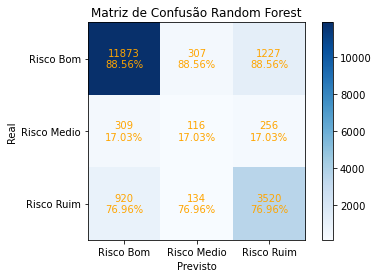

In [78]:
# matriz de confusão para avaliação do método Random Forest

# importando as bibliotecas
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# gera e imprime a matriz de confusão
cm = confusion_matrix(y_teste, y_pred_RF)
print(cm)

# Calcular a acurácia para cada categoria
total_registros = cm.sum(axis=1)  # Total de registros em cada categoria
acuracia_por_categoria = cm.diagonal() / total_registros

# Formatar os percentuais como string
percentuais_formatados = ['{:.2%}'.format(acuracia) for acuracia in acuracia_por_categoria]

# Plot da matriz de confusão com as frequências
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_title('Matriz de Confusão Random Forest')
ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])
ax.set_xticklabels(['Risco Bom', 'Risco Medio', 'Risco Ruim'])
ax.set_yticklabels(['Risco Bom', 'Risco Medio', 'Risco Ruim'])
ax.set_xlabel('Previsto')
ax.set_ylabel('Real')
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, f"{cm[i, j]}\n{percentuais_formatados[i]}", ha="center", va="center", color="orange")
#        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="orange")
plt.colorbar(im)
plt.show()

In [79]:
# cálculo das métricas de avaliação

# importando a biblioteca
from sklearn.metrics import classification_report

# Calcular as métricas de avaliação
report = classification_report(y_teste, y_pred_RF, target_names=["Risco Bom", "Risco Médio", "Risco Ruim"], output_dict=True)

# Exibir as métricas de avaliação
print("Métricas de Avaliação:")
print("Risco Bom: Precisão = {:.2%}, Revocação = {:.2%}, F1-Score = {:.2%}".format(
    report["Risco Bom"]["precision"], report["Risco Bom"]["recall"], report["Risco Bom"]["f1-score"]))
print("Risco Médio: Precisão = {:.2%}, Revocação = {:.2%}, F1-Score = {:.2%}".format(
    report["Risco Médio"]["precision"], report["Risco Médio"]["recall"], report["Risco Médio"]["f1-score"]))
print("Risco Ruim: Precisão = {:.2%}, Revocação = {:.2%}, F1-Score = {:.2%}".format(
    report["Risco Ruim"]["precision"], report["Risco Ruim"]["recall"], report["Risco Ruim"]["f1-score"]))

# Criar a tabela de distribuição predita e real
predita = [report["Risco Bom"]["support"], report["Risco Médio"]["support"], report["Risco Ruim"]["support"]]
real = [report["Risco Bom"]["precision"], report["Risco Médio"]["precision"], report["Risco Ruim"]["precision"]]
percentual_predita = [report["Risco Bom"]["support"] / len(y_teste), report["Risco Médio"]["support"] / len(y_teste), report["Risco Ruim"]["support"] / len(y_teste)]
percentual_real = [report["Risco Bom"]["precision"], report["Risco Médio"]["precision"], report["Risco Ruim"]["precision"]]

# Exibir a tabela de distribuição predita e real
print("\nTabela de Distribuição Preditiva e Real:")
print("Categoria\tDistribuição Preditiva\tDistribuição Real")
print("Risco Bom\t{:>10}\t\t{:.2%}".format(predita[0], percentual_predita[0]))
print("Risco Médio\t{:>10}\t\t{:.2%}".format(predita[1], percentual_predita[1]))
print("Risco Ruim\t{:>10}\t\t{:.2%}".format(predita[2], percentual_predita[2]))

Métricas de Avaliação:
Risco Bom: Precisão = 90.62%, Revocação = 88.56%, F1-Score = 89.58%
Risco Médio: Precisão = 20.83%, Revocação = 17.03%, F1-Score = 18.74%
Risco Ruim: Precisão = 70.36%, Revocação = 76.96%, F1-Score = 73.51%

Tabela de Distribuição Preditiva e Real:
Categoria	Distribuição Preditiva	Distribuição Real
Risco Bom	     13407		71.84%
Risco Médio	       681		3.65%
Risco Ruim	      4574		24.51%


In [82]:
# treinando o modelo com uma rede neural 

# instalando a biblioteca
# pip install tensorflow

# importando as bibliotecas
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
import keras.datasets as kds

# treinando com uma rede neural MLP (multi-layer perceptron) com uma camada oculta com 7 neurônios

# definindo os neurônios e as camadas
num_classes = 3
input_shape = (29, 7, 1)

# Normalização das features
x_treino = x_treino.astype("float32") / 255
x_teste = x_teste.astype("float32") / 255

modelo_MLP = keras.Sequential()
modelo_MLP.add(keras.layers.Flatten(input_shape=input_shape))
modelo_MLP.add(keras.layers.Dense(units=7, activation="relu"))
modelo_MLP.add(keras.layers.Dense(units=1, activation="softmax"))

modelo_MLP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 203)               0         
                                                                 
 dense (Dense)               (None, 7)                 1428      
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 1,436
Trainable params: 1,436
Non-trainable params: 0
_________________________________________________________________


In [83]:
# treinando o modelo

modelo_MLP.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = modelo_MLP.fit(x_treino, y_treino, batch_size=256, epochs=30, validation_split=0.2, verbose=2)

Epoch 1/30


ValueError: in user code:

    File "C:\Users\LUIZK\Anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\LUIZK\Anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\LUIZK\Anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\LUIZK\Anaconda3\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\LUIZK\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\LUIZK\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 203, but received input with shape (None, 29)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 29), dtype=float32)
      • training=True
      • mask=None
